# Chapter 11

In [ ]:
library(MASS)

## be careful to load dplyr after MASS
library(dplyr)
library(tidyr)
library(purrr)
library(extraDistr)
library(ggplot2)
library(loo)
library(bridgesampling)
library(brms)
library(bayesplot)
library(tictoc)
library(hypr)
library(bcogsci)
library(lme4)
library(rstan)
# library(cmdstanr)
library(rootSolve)

In [3]:
## Save compiled models:
rstan_options(auto_write = FALSE)
## Parallelize the chains using all the cores:
options(mc.cores = parallel::detectCores())
# To solve some conflicts between packages
select <- dplyr::select
extract <- rstan::extract

In [4]:
data("df_eeg")

## Varying intercept model with Stan

$$
\begin{equation}
  signal_n \sim \mathit{Normal}(\alpha + u_{subj[n]} + c\_cloze_n \cdot \beta,\sigma)
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\alpha &\sim \mathit{Normal}(0,10)\\
\beta  &\sim \mathit{Normal}(0,10)\\
u &\sim \mathit{Normal}(0,\tau_u)\\
\tau_{u} &\sim \mathit{Normal}_+(0,20) \\
\sigma  &\sim \mathit{Normal}_+(0,50)
\end{aligned}
\end{equation}
$$

In [5]:
# center load variable
df_eeg <- df_eeg %>%
  mutate(c_cloze = cloze - mean(cloze))

In [6]:
# define data for Stan model
ls_eeg <- list(
  N = nrow(df_eeg),
  signal = df_eeg$n400,
  c_cloze = df_eeg$c_cloze,
  subj = df_eeg$subj,
  N_subj = max(df_eeg$subj)
)

In [9]:
# fit model
fit_n400_1 <- stan("stan_models/n400_hierarchical.stan", data = ls_eeg)

Warning message in FUN(X[[i]], ...):
"tekst niereprezentowalny w natywnym kodowaniu bedzie przetlumaczony na UTF-8"


In [11]:
print(fit_n400_1, pars = c("alpha", "beta", "sigma", "tau_u"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha  3.62    0.01 0.43  2.81  3.33  3.63  3.90  4.47  1643    1
beta   2.31    0.01 0.54  1.24  1.95  2.32  2.66  3.39  5324    1
sigma 11.64    0.00 0.15 11.35 11.53 11.63 11.74 11.94  4754    1
tau_u  2.18    0.01 0.37  1.55  1.92  2.16  2.41  3.00  2247    1

Samples were drawn using NUTS(diag_e) at Sat Sep 10 13:23:49 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



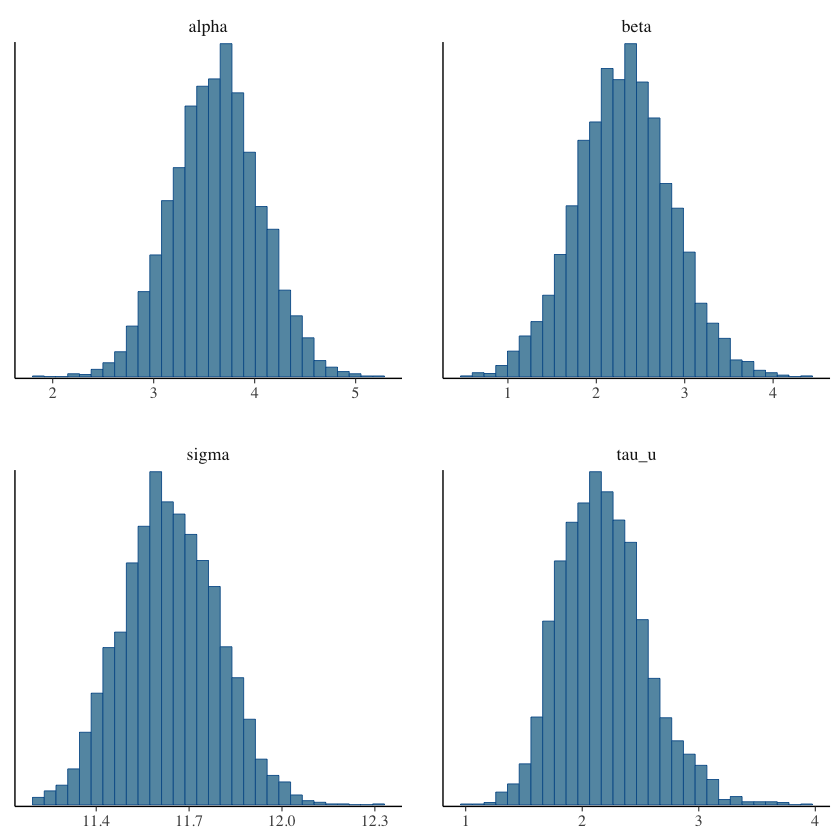

In [12]:
# cast to df
df_fit_n400_1 <- as.data.frame(fit_n400_1)

mcmc_hist(df_fit_n400_1[1:4])

## Uncorrelated varying intercept and slopes model with Stan

$$
\begin{equation}
  signal_n \sim \mathit{Normal}(\alpha + u_{subj[n],1} + c\_cloze_n \cdot (\beta+ u_{subj[n],2}),\sigma)
\tag{11.1}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\alpha &\sim \mathit{Normal}(0,10)\\
\beta  &\sim \mathit{Normal}(0,10)\\
u_1 &\sim \mathit{Normal}(0,\tau_{u_1})\\
u_2 &\sim \mathit{Normal}(0,\tau_{u_2})\\
\tau_{u_1} &\sim \mathit{Normal}_+(0,20) \\
\tau_{u_2} &\sim \mathit{Normal}_+(0,20) \\
\sigma  &\sim \mathit{Normal}_+(0,50)
\end{aligned}
\tag{11.2}
\end{equation}
$$

In [13]:
# define data for Stan model

ls_eeg <- list(
  N = nrow(df_eeg),
  signal = df_eeg$n400,
  c_cloze = df_eeg$c_cloze,
  subj = df_eeg$subj,
  N_subj = max(df_eeg$subj)
)

In [14]:
# fit model
fit_n400_2 <- stan("stan_models/n400_hierarchical_varying_IS.stan", data = ls_eeg)

Warning message:
"There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 1.06, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


In [35]:
print(fit_n400_2, pars = c("alpha", "beta", "tau_u", "sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha     3.64    0.01 0.42  2.79  3.37  3.63  3.92  4.48  1107 1.00
beta      2.33    0.01 0.61  1.12  1.91  2.33  2.75  3.53  3820 1.00
tau_u[1]  2.20    0.01 0.38  1.54  1.93  2.16  2.42  3.05  2437 1.00
tau_u[2]  1.66    0.10 0.89  0.09  1.01  1.63  2.25  3.50    80 1.05
sigma    11.62    0.00 0.16 11.32 11.51 11.62 11.72 11.94  6132 1.00

Samples were drawn using NUTS(diag_e) at Sat Sep 10 14:09:13 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Correlated varying intercept varying slopes model

$$
\begin{equation}
  signal_n \sim \mathit{Normal}(\alpha + u_{subj[n],1} + c\_cloze_n \cdot  (\beta + u_{subj[n],2}),\sigma)
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\alpha & \sim \mathit{Normal}(0,10) \\
\beta  & \sim \mathit{Normal}(0,10) \\
  \sigma  &\sim \mathit{Normal}_+(0,50)\\
  {\begin{pmatrix}
  u_{i,1} \\
  u_{i,2}
  \end{pmatrix}}
&\sim {\mathcal {N}}
  \left(
{\begin{pmatrix}
  0\\
  0
\end{pmatrix}}
,\boldsymbol{\Sigma_u} \right)
\end{aligned}
\end{equation}
$$

$$
\begin{equation}
\boldsymbol{\Sigma_u} =
{\begin{pmatrix}
\tau_{u_1}^2 & \rho_u \tau_{u_1} \tau_{u_2} \\
\rho_u \tau_{u_1} \tau_{u_2} & \tau_{u_2}^2
\end{pmatrix}}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\tau_{u_1} &\sim \mathit{Normal}_+(0,20)\\
\tau_{u_2} &\sim \mathit{Normal}_+(0,20)\\
\rho_u &\sim \mathit{LKJcorr}(2)
\end{aligned}
\end{equation}
$$

In [ ]:
# fit model
fit_n400_2 <- stan("stan_models/n400_hierarchical_corr_IS.stan", data = ls_eeg)

Again, we have bad mixing of the chains for tau_u[2].

The problem (which can also be discovered in a pairs plot) is the same one that we saw before: There is a strong correlation between tau_u[2] (in fact, log(tau_u[2]), which is the parameter dimension that the sampler considers) and u, creating a funnel.

In [23]:
print(fit_n400_2, pars = c("alpha", "beta", "tau_u", "sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha     3.64    0.01 0.42  2.79  3.37  3.63  3.92  4.48  1107 1.00
beta      2.33    0.01 0.61  1.12  1.91  2.33  2.75  3.53  3820 1.00
tau_u[1]  2.20    0.01 0.38  1.54  1.93  2.16  2.42  3.05  2437 1.00
tau_u[2]  1.66    0.10 0.89  0.09  1.01  1.63  2.25  3.50    80 1.05
sigma    11.62    0.00 0.16 11.32 11.51 11.62 11.72 11.94  6132 1.00

Samples were drawn using NUTS(diag_e) at Sat Sep 10 14:09:13 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


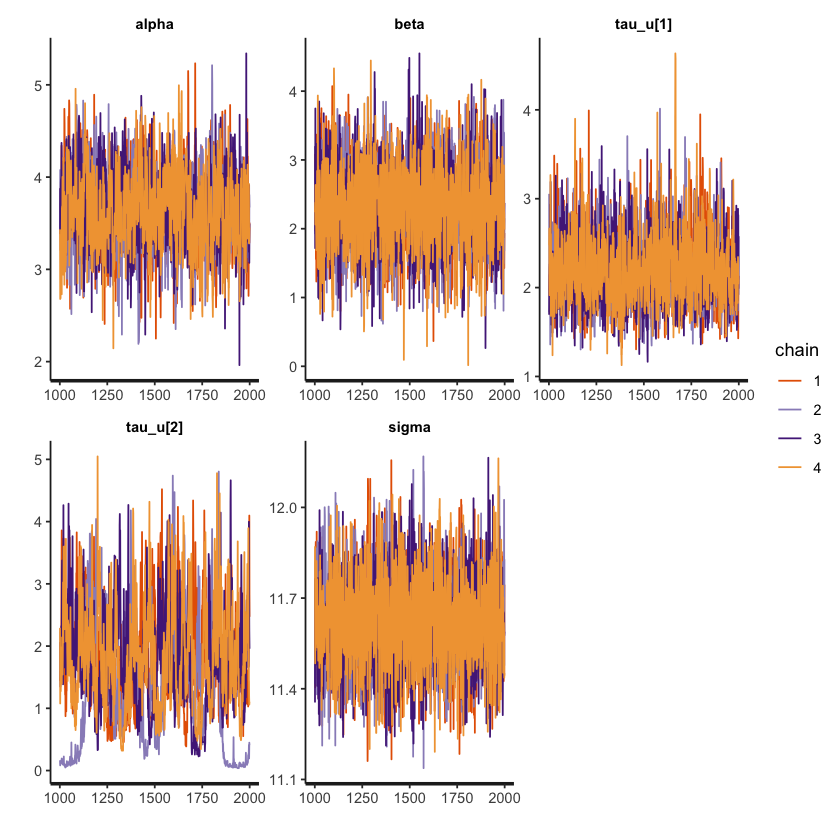

In [25]:
traceplot(fit_n400_2, pars = c("alpha", "beta", "tau_u", "sigma"))

## By-subject and by-items correlated varying intercept varying slopes model

$$
\begin{equation}
  signal_n \sim \mathit{Normal}(\alpha + u_{subj[n], 1} + w_{item[n], 1} +
  c\_cloze_n \cdot  (\beta + u_{subj[n],2} + w_{item[n], 2}),\sigma)
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\alpha & \sim \mathit{Normal}(0,10) \\
\beta  & \sim \mathit{Normal}(0,10) \\
  \sigma  &\sim \mathit{Normal}_+(0, 50)\\
    {\begin{pmatrix}
  u_{i,1} \\
  u_{i,2}
  \end{pmatrix}}
&\sim {\mathcal {N}}
  \left(
{\begin{pmatrix}
  0\\
  0
\end{pmatrix}}
,\boldsymbol{\Sigma_u} \right) \\
   {\begin{pmatrix}
  w_{i,1} \\
  w_{i,2}
  \end{pmatrix}}
&\sim {\mathcal {N}}
  \left(
{\begin{pmatrix}
  0\\
  0
\end{pmatrix}}
,\boldsymbol{\Sigma_w} \right)
\end{aligned}
\end{equation}
$$

In [26]:
# center variable item
df_eeg <- df_eeg %>%
  mutate(item = as.numeric(as.factor(item)))

In [27]:
# create data for Stan model
ls_eeg <- list(
  N = nrow(df_eeg),
  signal = df_eeg$n400,
  c_cloze = df_eeg$c_cloze,
  subj = df_eeg$subj,
  item = df_eeg$item,
  N_subj = max(df_eeg$subj),
  N_item = max(df_eeg$item))

In [28]:
fit_eeg_corr_by <- stan("stan_models/n400_hierarchical_corr_IS_item_corrected.stan", data = ls_eeg)

In [29]:
print(fit_eeg_corr_by,
  pars = c("alpha", "beta", "sigma", "tau_u", "tau_w", "rho_u", "rho_w"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha       3.67    0.01 0.46  2.77  3.36  3.66  3.97  4.59  2228    1
beta        2.31    0.01 0.68  0.93  1.86  2.32  2.77  3.61  5073    1
sigma      11.49    0.00 0.16 11.18 11.38 11.48 11.59 11.82  5564    1
tau_u[1]    2.21    0.01 0.38  1.55  1.94  2.18  2.44  3.05  1924    1
tau_u[2]    1.51    0.03 0.90  0.09  0.77  1.46  2.13  3.38  1185    1
tau_w[1]    1.50    0.01 0.35  0.79  1.27  1.51  1.73  2.17  1181    1
tau_w[2]    2.31    0.03 1.03  0.28  1.60  2.33  3.02  4.30  1138    1
rho_u[1,1]  1.00     NaN 0.00  1.00  1.00  1.00  1.00  1.00   NaN  NaN
rho_u[1,2]  0.13    0.01 0.36 -0.64 -0.12  0.15  0.39  0.78  4875    1
rho_u[2,1]  0.13    0.01 0.36 -0.64 -0.12  0.15  0.39  0.78  4875    1
rho_u[2,2]  1.00    0.00 0.00  1.00  1.00  1.00  1.00  1.00  36

In [36]:
mcmc_hist(as.data.frame(fit_eeg_corr_by),
  pars = c("alpha", "beta", "sigma", "rho_u[1,2]", "rho_w[1,2]")
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



ERROR: Error in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : nie znaleziono krawedzi wielokata


plot without title

In [42]:
head(as.data.frame(fit_eeg_corr_by))

,sigma,tau_u[1],tau_u[2],tau_w[1],tau_w[2],alpha,beta,"z_u[1,1]","z_u[2,1]","z_u[1,2]",⋯,"w[80,2]","rho_u[1,1]","rho_u[2,1]","rho_u[1,2]","rho_u[2,2]","rho_w[1,1]","rho_w[2,1]","rho_w[1,2]","rho_w[2,2]",lp__
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,11.42731,2.648775,3.101743,1.575959,2.7315546,3.070930,2.141262,1.03990832,-0.948204269,-0.07979825,⋯,4.2744532,1,0.49598054,0.49598054,1,1,-0.4798683,-0.4798683,1,-11389.71
2,11.45966,2.290508,3.464274,1.722849,3.1564316,2.968029,1.150138,0.47226553,0.006446571,-0.46196870,⋯,-0.6813576,1,0.27583481,0.27583481,1,1,-0.4628359,-0.4628359,1,-11378.87
3,11.64481,2.644096,2.541806,1.832041,2.1971694,4.144196,3.321549,0.63562174,-0.265522937,-0.86718235,⋯,2.0644900,1,0.20651873,0.20651873,1,1,-0.6759470,-0.6759470,1,-11387.59
4,11.73948,1.496344,3.122183,1.485042,0.9431758,3.938580,2.352040,0.03660147,-0.201122636,-0.45306926,⋯,-0.4477828,1,0.31927400,0.31927400,1,1,-0.7620738,-0.7620738,1,-11391.62
5,11.24263,2.394510,2.488947,1.414651,1.3596088,3.872498,2.368005,0.59905191,-1.065696401,-0.43894187,⋯,0.6216572,1,-0.05672271,-0.05672271,1,1,-0.7492056,-0.7492056,1,-11378.56
6,11.61640,2.011437,1.735267,1.846907,2.4284406,3.682473,1.642966,-0.06269764,0.123591061,-0.69857262,⋯,-0.2807283,1,0.28861067,0.28861067,1,1,-0.4350421,-0.4350421,1,-11391.64


#### Adjustment to the slope (beta)

In [64]:
# make a table of u_2s
ind_effects_v <- paste0("u[", unique(df_eeg$subj), 
                        ",2]")
ind_effects_v

[1] "u[1,2]"  "u[2,2]"  "u[3,2]"  "u[4,2]"  "u[5,2]"  "u[6,2]"  "u[7,2]" 
 [8] "u[8,2]"  "u[9,2]"  "u[10,2]" "u[11,2]" "u[12,2]" "u[13,2]" "u[14,2]"
[15] "u[15,2]" "u[16,2]" "u[17,2]" "u[18,2]" "u[19,2]" "u[20,2]" "u[21,2]"
[22] "u[22,2]" "u[23,2]" "u[24,2]" "u[25,2]" "u[26,2]" "u[27,2]" "u[28,2]"
[29] "u[29,2]" "u[30,2]" "u[31,2]" "u[32,2]" "u[33,2]" "u[34,2]" "u[35,2]"
[36] "u[36,2]" "u[37,2]"

In [66]:
adjustment <- as.data.frame(fit_eeg_corr_by)[ind_effects_v]
beta <- as.data.frame(fit_eeg_corr_by)$beta
by_subj_effect <- as.data.frame(beta + adjustment)

In [82]:
par_h <- lapply(by_subj_effect, function(x) {
  tibble(
    Estimate = mean(x),
    Q2.5 = quantile(x, .025),
    Q97.5 = quantile(x, .975)
  )
}) %>%
  bind_rows() %>%
  # Add a column to identify that the model,
  # and one with the subject labels:
  mutate(
    model = "Hierarchical",
    subj = unique(df_eeg$subj)
  ) %>%
  arrange(Estimate) %>%
  mutate(subj = factor(subj, levels = unique(.data$subj)))

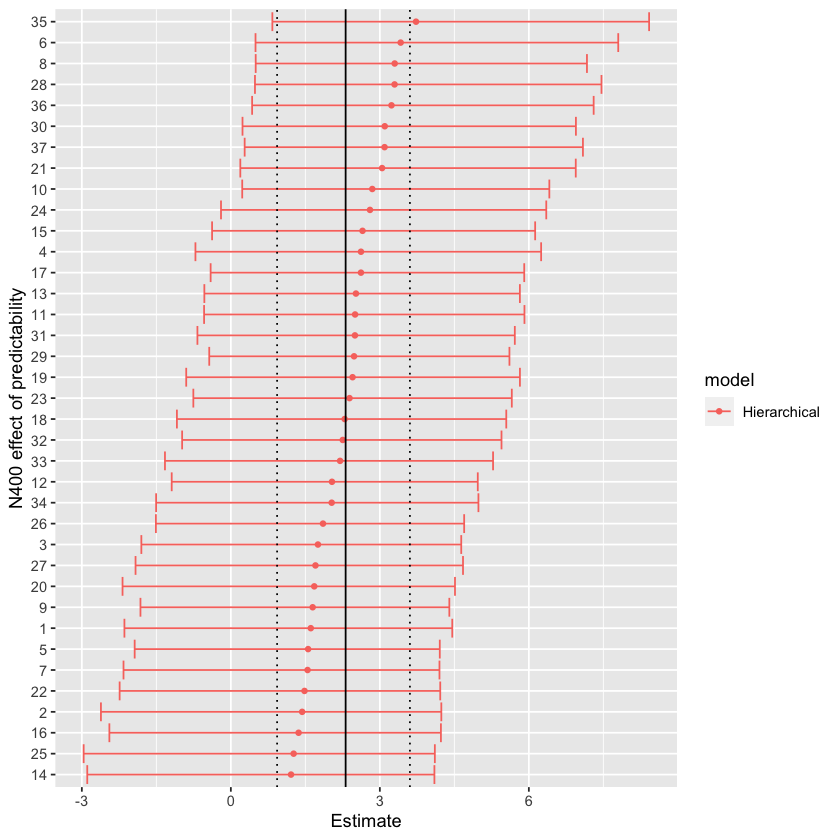

In [88]:
ggplot(
  par_h,
  aes(
    ymin = Q2.5, ymax = Q97.5, x = subj, y = Estimate, color = model,
    shape = model
  )
) +
  geom_errorbar(position = position_dodge(1)) +
  geom_point(position = position_dodge(1)) +
  # We'll also add the mean and 95% CrI of the overall difference
  # to the plot:
  geom_hline(
    yintercept =
      mean(beta)
  ) +
  geom_hline(
    yintercept =
      quantile(beta, .025),
    linetype = "dotted", size = .5
  ) +
  geom_hline(
    yintercept =
      quantile(beta, .975),
    linetype = "dotted", size = .5
  ) +
  xlab("N400 effect of predictability") +
  coord_flip()